## Introduction

The goal of this notebook is to baseline standard machine learning models' classifying accuracy against pre-recorded field detector data.

Background: The goal of this project is to use machine learning to determine whether or not to shut down transmitted RF power. When transmitting high RF power, it is possible for a person to cross the main beam and become over exposed (according to FCC specific absorbtion limits).

This experiment attempted to classify various movements around the transmitter. Three field detectors were placed around a transmitting antenna, and data was recorded using USB microphones at 8kHz (The USB microphones were hacked to record the electrical outputs of the field detectors).

<img src="field_detector_setup.jpg">


Various movement examples such as walking alongside the transmitter, walking through the main beam, and no movement at all were recorded using the attached script `record_data.py`.

The idea was, that we'd prefer the detector to ignore movements such as walking along side the beam (the detector can pick up any sort of movement either inside or outside of the main transmit beam).

## Feature Extraction

After recording the data at 8kHz, a seperate program `generate_features.py` then goes through each file and computes the features the ML models will then train on. The most important features were the spectral energies in the time series signal. The time series signal is convolved by a series of filter banks, each with a bandwidth of 100Hz. Each filter bank is placed at 0Hz, 100Hz, 200Hz, up to 1.9kHz. 

Other features that proved less useful were:
* max power
* variance
* 25th quartile power
* 50th quartile power (median)
* 75th quartile power

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

pd.set_option('display.max_columns', None)

## Feature Exploration

In [10]:
features_dir = os.path.join('RecordedData', 'Features')

features_path = os.path.join(features_dir, 'headers.txt')

with open(features_path, 'r') as f:
    columns = f.readline().split(',')

features = [
    [
        float(val) if col != 'label' else val 
        for col, val in zip(columns, np.load(os.path.join(features_dir, f)))
    ]
    
    for f in os.listdir(features_dir)
    if '.npy' in f
]

label2val = {
    'AMBIENT' : 0,
    'STANDING': 1,
    'WALKSIDE': 2,
    'WALKTHRU': 3,
}

data = pd.DataFrame(features, columns=columns)
data.head()

,f0,f100,f200,f300,f400,f500,f600,f700,f800,f900,f1000,f1100,f1200,f1300,f1400,f1500,f1600,f1700,f1800,f1900,pwr_max,var,pwr_q25,pwr_q50,qr_q75,label
0,0.911112,0.004727,0.002071,0.003873,0.052405,0.000262,0.000833,0.000452,0.000157,0.000566,0.000043,0.008149,0.000313,0.001012,0.000511,0.000027,0.000483,0.000017,0.000097,0.000197,8.995407,0.314556,0.014331,0.068680,0.254748,WALKTHRU
1,0.000917,0.068000,0.015259,0.041967,0.683578,0.002068,0.008928,0.004688,0.001499,0.006037,0.000205,0.073069,0.004684,0.010607,0.005743,0.000208,0.005351,0.000097,0.000269,0.003819,1.667806,0.122742,0.019823,0.073919,0.174333,STANDING
2,0.001373,0.047907,0.023875,0.043445,0.640260,0.003111,0.010533,0.005525,0.001781,0.007179,0.000349,0.106408,0.003722,0.012872,0.006419,0.000280,0.006005,0.000152,0.001427,0.002081,3.025453,0.239939,0.035745,0.135920,0.343509,AMBIENT
3,0.001627,0.047962,0.023715,0.043592,0.638774,0.003227,0.010552,0.005530,0.001788,0.007091,0.000358,0.106984,0.003690,0.012851,0.006442,0.000261,0.006337,0.000140,0.001371,0.002139,2.550185,0.191672,0.028861,0.109745,0.268482,AMBIENT
4,0.960934,0.006448,0.000260,0.000581,0.007481,0.000041,0.000106,0.000060,0.000019,0.000073,0.000009,0.001005,0.000042,0.000129,0.000067,0.000003,0.000064,0.000003,0.000014,0.000024,6.833225,0.381678,0.025883,0.106490,0.360203,WALKTHRU


In [11]:
# convert the string label to a numerical label
data['y'] = data['label'].apply(lambda label: label2val[label]) 

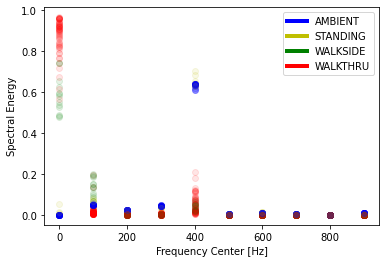

In [12]:
# plot the frequencies versus label
freqs = ['f0', 'f100', 'f200', 'f300', 'f400', 'f500', 'f600', 'f700', 'f800', 'f900']

x = np.arange(10) * 100

colormap = {
    0: 'b',
    1: 'y',
    2: 'g',
    3: 'r',
}

for row in data.iloc:
    energies = row[freqs]
    label = row['y']
    
    plt.plot(x, energies.values, 'o', color=colormap[label], alpha=.1)
    
# have to draw a custom legend
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='y', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='r', lw=4)]

plt.gca().legend(custom_lines, ['AMBIENT', 'STANDING', 'WALKSIDE', 'WALKTHRU'])
plt.xlabel('Frequency Center [Hz]')
plt.ylabel('Spectral Energy');

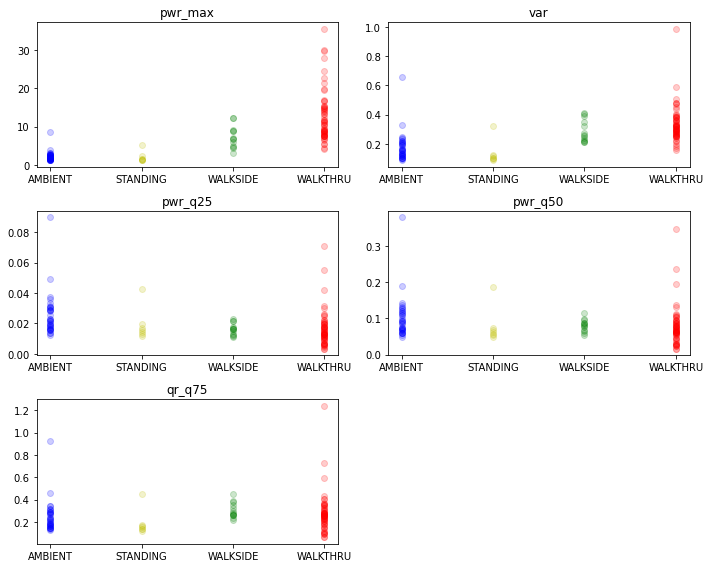

In [13]:
# plot the rest of the features against eachother

#feats = ['pwr_max', 'var', 'pwr_q25', 'pwr_q50', 'qr_q75']

plt.figure(figsize=(10, 8))

def plot_feature(f):
    for row in data.iloc:
        val = row[f]
        label = row['y']   
        plt.plot(label, val, 'o', color=colormap[label], alpha=.2)

    labels = ['AMBIENT', 'STANDING', 'WALKSIDE', 'WALKTHRU']
    xticks = [0, 1, 2, 3]
    
    plt.gca().set_xticks(xticks)
    plt.gca().set_xticklabels(labels)
    plt.title(f)
    

plt.subplot(321)
plot_feature('pwr_max')

plt.subplot(322)
plot_feature('var')

plt.subplot(323)
plot_feature('pwr_q25')

plt.subplot(324)
plot_feature('pwr_q50')

plt.subplot(325)
plot_feature('qr_q75')
plt.tight_layout()


### Remarks
Doesn't seem like there's a discernable pattern between the labels using statistical data.

## Thoughts on Model Performance

* The estimator should be conservative, meaning we'd prefer it generate more false positives than false negatives. Positive being a field disruption.

* That being said, it would be annoying if the field detector triggered positive at random when the system is idling and there is no movement.

## Vanilla SVM Multiclass

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore') 

In [15]:
def evaluate_avg_f1_score(model, X, y):
    scores = []
    for train, test in KFold(n_splits=3, random_state=42, shuffle=True).split(X):
        X_train, y_train = X.iloc[train], y.iloc[train]
        X_test, y_test = X.iloc[test], y.iloc[test]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        score = f1_score(y_test, y_pred, average='weighted')
        
        scores.append(score)
    
    return np.average(scores)

In [16]:
def pretty_confusion_matrix(y_true, y_pred, class_labels):
    cf = pd.DataFrame(
        confusion_matrix(
            y_true,
            y_pred
        ), 
        columns=['Guess ' + l for l in class_labels]
    )

    cf.index = ['True ' + l for l in class_labels]
    return cf


In [17]:
def evaluate_over_all_test_data(model, X, y, class_labels):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.4, random_state=42)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    print(classification_report(y_test, y_pred, target_names=class_labels))

    return pretty_confusion_matrix(y_test, y_pred, class_labels)

In [18]:
# Train a SVM to see how well it does
X = data.drop(['label', 'y'], axis=1)
y = data['y']

class_labels = ['AMBIENT', 'STANDING', 'WALKSIDE', 'WALKTHRU']

evaluate_over_all_test_data(SVC(), X, y, class_labels)


Accuracy:  0.7777777777777778
              precision    recall  f1-score   support

     AMBIENT       0.65      1.00      0.79        11
    STANDING       0.00      0.00      0.00         5
    WALKSIDE       0.00      0.00      0.00         4
    WALKTHRU       0.86      0.96      0.91        25

    accuracy                           0.78        45
   macro avg       0.38      0.49      0.42        45
weighted avg       0.63      0.78      0.70        45



,Guess AMBIENT,Guess STANDING,Guess WALKSIDE,Guess WALKTHRU
True AMBIENT,11,0,0,0
True STANDING,5,0,0,0
True WALKSIDE,0,0,0,4
True WALKTHRU,1,0,0,24


In [19]:
evaluate_avg_f1_score(SVC(), X, y)

0.716950667884454

## SVM with less features, Multiclass


In [20]:
# Train a SVM to see how well it does

freqs = ['f0', 'f100', 'f200', 'f300', 'f400', 'f500', 'f600', 'f700', 'f800', 'f900']

class_labels = ['AMBIENT', 'STANDING', 'WALKSIDE', 'WALKTHRU']

evaluate_over_all_test_data(SVC(), X[freqs], y, class_labels)


Accuracy:  0.8666666666666667
              precision    recall  f1-score   support

     AMBIENT       0.69      1.00      0.81        11
    STANDING       0.00      0.00      0.00         5
    WALKSIDE       0.80      1.00      0.89         4
    WALKTHRU       1.00      0.96      0.98        25

    accuracy                           0.87        45
   macro avg       0.62      0.74      0.67        45
weighted avg       0.79      0.87      0.82        45



,Guess AMBIENT,Guess STANDING,Guess WALKSIDE,Guess WALKTHRU
True AMBIENT,11,0,0,0
True STANDING,5,0,0,0
True WALKSIDE,0,0,4,0
True WALKTHRU,0,0,1,24


In [21]:
evaluate_avg_f1_score(SVC(), X[freqs], y)

0.8732134442461813

### Remarks
Performance increases if we only use meaningful features

## SVM - Less Sensitive to Out of Field Movement, Binary


In [22]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 0,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(SVC(), X[freqs], y_reduced, class_labels)


Accuracy:  0.9777777777777777
              precision    recall  f1-score   support

        IDLE       0.95      1.00      0.98        20
        TRIG       1.00      0.96      0.98        25

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



,Guess IDLE,Guess TRIG
True IDLE,20,0
True TRIG,1,24


In [23]:
evaluate_avg_f1_score(SVC(), X[freqs], y_reduced)

0.9550079891543305

### Remarks

Moved class labels standing and walking along the side of the field detector to ambient to make the detector more immune to false triggers. 

This means, to get it to trigger, you have to really mean it.

## SVM - Very Sensitive, Binary

In [24]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 1,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

y_reduced.value_counts()
evaluate_over_all_test_data(SVC(), X[freqs], y_reduced, class_labels)


Accuracy:  1.0
              precision    recall  f1-score   support

        IDLE       1.00      1.00      1.00        16
        TRIG       1.00      1.00      1.00        29

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



,Guess IDLE,Guess TRIG
True IDLE,16,0
True TRIG,0,29


In [25]:
evaluate_avg_f1_score(SVC(), X[freqs], y_reduced)

1.0

### Remarks

The classifier gets all of the test data points correct when we make it sensitive to field disturbances outside of the main beam.

## Logistic Regression - Immune to Out of Field Disturbances


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [29]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 0,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(LogisticRegression(), X[freqs], y_reduced, class_labels)


Accuracy:  0.9333333333333333
              precision    recall  f1-score   support

        IDLE       1.00      0.85      0.92        20
        TRIG       0.89      1.00      0.94        25

    accuracy                           0.93        45
   macro avg       0.95      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



,Guess IDLE,Guess TRIG
True IDLE,17,3
True TRIG,0,25


### Remark
The classifier is very sensitive and prone to giving false triggers. It is trigger happy.

In [30]:
evaluate_avg_f1_score(LogisticRegression(), X[freqs], y_reduced)

0.8902757076373077

In [31]:
def plot_roc_curve(model, X, y):
    # plot the auc curve to determine which threshold to use
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.4, random_state=42)

    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
    
    print('thresholds: ', thresholds)
    
    plt.plot(fpr, tpr, '.')
    plt.xlabel('False positive rate')
    plt.ylabel('Recall')
    plt.grid(True)

thresholds:  [1.82943442 0.82943442 0.67236092 0.56959755 0.55049108 0.09052706]


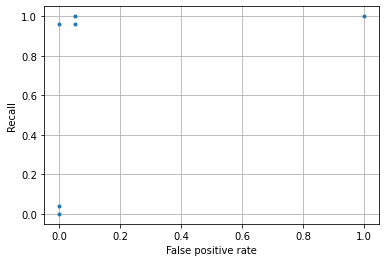

In [32]:
plot_roc_curve(LogisticRegression(), X[freqs], y_reduced)

## Logistic Regression - Very Sensitive

In [33]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 1,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(LogisticRegression(), X[freqs], y_reduced, class_labels)

Accuracy:  1.0
              precision    recall  f1-score   support

        IDLE       1.00      1.00      1.00        16
        TRIG       1.00      1.00      1.00        29

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



,Guess IDLE,Guess TRIG
True IDLE,16,0
True TRIG,0,29


In [35]:
evaluate_avg_f1_score(LogisticRegression(), X[freqs], y_reduced)

1.0

### Remarks
The classifier gets everything right when we make it sensitive to all field movements

thresholds:  [1.94628474 0.94628474 0.79143904 0.14825533]


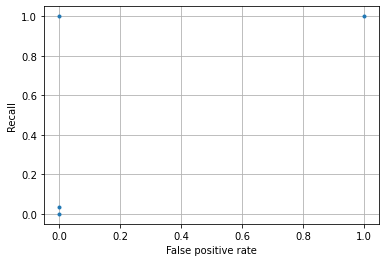

In [36]:
plot_roc_curve(LogisticRegression(), X[freqs], y_reduced)

## Naive Bayes, Multiclass

Treat each frequency bin as a gaussian random variable independent from one another

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
X = data.drop(['label', 'y'], axis=1)
y = data['y']

class_labels = ['AMBIENT', 'STANDING', 'WALKSIDE', 'WALKTHRU']

evaluate_over_all_test_data(GaussianNB(), X[freqs], y, class_labels)


Accuracy:  0.9555555555555556
              precision    recall  f1-score   support

     AMBIENT       1.00      1.00      1.00        11
    STANDING       1.00      0.80      0.89         5
    WALKSIDE       0.80      1.00      0.89         4
    WALKTHRU       0.96      0.96      0.96        25

    accuracy                           0.96        45
   macro avg       0.94      0.94      0.93        45
weighted avg       0.96      0.96      0.96        45



,Guess AMBIENT,Guess STANDING,Guess WALKSIDE,Guess WALKTHRU
True AMBIENT,11,0,0,0
True STANDING,0,4,0,1
True WALKSIDE,0,0,4,0
True WALKTHRU,0,0,1,24


In [39]:
evaluate_avg_f1_score(GaussianNB(), X[freqs], y)

0.9629167970631385

### Remarks
Wow, naive bayes performs really well for multi-classification

## Naive Bayes, Less Sensitive, Binary

In [40]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 0,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(GaussianNB(), X[freqs], y_reduced, class_labels)


Accuracy:  0.9111111111111111
              precision    recall  f1-score   support

        IDLE       0.94      0.85      0.89        20
        TRIG       0.89      0.96      0.92        25

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45



,Guess IDLE,Guess TRIG
True IDLE,17,3
True TRIG,1,24


In [41]:
evaluate_avg_f1_score(GaussianNB(), X[freqs], y_reduced)

0.8636782886782887

## Naive Bayes, Sensitive, Binary

In [42]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 1,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(GaussianNB(), X[freqs], y_reduced, class_labels)


Accuracy:  0.9777777777777777
              precision    recall  f1-score   support

        IDLE       1.00      0.94      0.97        16
        TRIG       0.97      1.00      0.98        29

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



,Guess IDLE,Guess TRIG
True IDLE,15,1
True TRIG,0,29


In [43]:
evaluate_avg_f1_score(GaussianNB(), X[freqs], y_reduced)

1.0

### Remarks
Like SVM and Logistic Regression, Naive Bayes performs very well when we make it very sensitive to any kind of movement.

It seems that the challenge is distinguishing between intentional field disruptions and ambient movement outside of the main field. 

## Decision Tree, Multiclass

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
X = data.drop(['label', 'y'], axis=1)
y = data['y']

class_labels = ['AMBIENT', 'STANDING', 'WALKSIDE', 'WALKTHRU']

evaluate_over_all_test_data(
    DecisionTreeClassifier(),
    X[freqs], 
    y, 
    class_labels
)

Accuracy:  0.9555555555555556
              precision    recall  f1-score   support

     AMBIENT       1.00      1.00      1.00        11
    STANDING       1.00      0.60      0.75         5
    WALKSIDE       1.00      1.00      1.00         4
    WALKTHRU       0.93      1.00      0.96        25

    accuracy                           0.96        45
   macro avg       0.98      0.90      0.93        45
weighted avg       0.96      0.96      0.95        45



,Guess AMBIENT,Guess STANDING,Guess WALKSIDE,Guess WALKTHRU
True AMBIENT,11,0,0,0
True STANDING,0,3,0,2
True WALKSIDE,0,0,4,0
True WALKTHRU,0,0,0,25


### Remarks
Very high accuracy, but worried it's overfitting the data - similar to the naive bayes classifier.
However retraining the data on random data gives different accuracies - meaning the model is highly sensitive to the data it's trained on. This may indicate over fitting and high model variance (which is expected of a decision tree). 

In [48]:
# Run this multiple times since DecisionTree has high variance

f1_scores = [
    evaluate_avg_f1_score(DecisionTreeClassifier(), X[freqs], y)
    for _ in range(20)
]

print('\n'.join('%.3f'%score for score in f1_scores))

print('average score: ', np.average(f1_scores))

0.978
0.978
0.970
0.978
0.978
0.978
0.978
0.978
0.978
0.978
0.978
0.978
0.978
0.978
0.978
0.969
0.978
0.978
0.969
0.978
average score:  0.9766807050953392


## Decision Tree, Sensitive, Binary

In [49]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 1,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(DecisionTreeClassifier(), X[freqs], y_reduced, class_labels)

Accuracy:  1.0
              precision    recall  f1-score   support

        IDLE       1.00      1.00      1.00        16
        TRIG       1.00      1.00      1.00        29

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



,Guess IDLE,Guess TRIG
True IDLE,16,0
True TRIG,0,29


In [50]:
# Run this multiple times since DecisionTree has high variance

f1_scores = [
    evaluate_avg_f1_score(DecisionTreeClassifier(), X[freqs], y_reduced)
    for _ in range(10)
]

print('\n'.join('%.3f'%score for score in f1_scores))

print('average score: ', np.average(f1_scores))

1.000
1.000
1.000
1.000
1.000
1.000
1.000
1.000
1.000
1.000
average score:  1.0


### Remarks
Exhibits 100% accuracy like the other models when it's trained to be sensitive to any field disturbances

## Decision Tree, Less Sensitive, Binary

In [55]:
label2disrupted = {
    'AMBIENT'  : 0,
    'STANDING' : 0,
    'WALKSIDE' : 0,
    'WALKTHRU' : 1,
}

X = data.drop(['label', 'y'], axis=1)
y = data['y']

y_reduced = data['label'].apply(lambda x: label2disrupted[x])

class_labels = ['IDLE', 'TRIG']

evaluate_over_all_test_data(DecisionTreeClassifier(), X[freqs], y_reduced, class_labels)

Accuracy:  0.9777777777777777
              precision    recall  f1-score   support

        IDLE       1.00      0.95      0.97        20
        TRIG       0.96      1.00      0.98        25

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.98        45
weighted avg       0.98      0.98      0.98        45



,Guess IDLE,Guess TRIG
True IDLE,19,1
True TRIG,0,25


In [56]:
# Run this multiple times since DecisionTree has high variance

f1_scores = [
    evaluate_avg_f1_score(DecisionTreeClassifier(), X[freqs], y_reduced)
    for _ in range(10)
]

print('\n'.join('%.3f'%score for score in f1_scores))

print('average score: ', np.average(f1_scores))

0.991
0.991
0.991
0.991
0.991
0.991
0.982
0.991
0.991
0.991
average score:  0.9900795534941876


### Remarks
Has very good accuracy, but worried it's overfit to experimental setup and won't translate to an actual router scenario. 